In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def gridsearch_timeseriessplit(dataframe, original_df, columns=[], test_size=1, maxlags=14):
    
    tss = TimeSeriesSplit(n_splits=10, test_size=test_size, gap=0)
    
    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []

    df_log = np.log(original_df[1:])
    cols = columns
    
    for train_idx, val_idx in tss.split(dataframe):
        scaler = StandardScaler()
        train = dataframe.iloc[train_idx]
        test = dataframe.iloc[val_idx]

        ## Original LOG values

        original_logs = pd.DataFrame()
        original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
        original_logs = original_logs[["eth_close"]]    

        ##SCALING
        scaler.fit(train[cols])
        train[cols] = scaler.transform(train[cols])
        test[cols]= scaler.transform(test[cols])
        
        train = pd.DataFrame(train, columns=cols)
        test = pd.DataFrame(test, columns=cols)

        #Model Fit
        model = VAR(train)
        results = model.fit(maxlags=maxlags)
        lag_order = results.k_ar

        prior = train.iloc[-lag_order:][cols].to_numpy()
        fcast = results.forecast(prior, len(test))

        prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
        prediction.index = test.index
        prediction.columns = ["scaled_prediction"]
        backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
        prediction["unscaled_predictions"] = backscaled_fcast[:, -1]

        evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    
        
        ##UN-DIFFERENCING
        x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
        evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff
        
        ##EXP
        evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
        evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
        evaluation_df = evaluation_df[1:]
        
    try:
        rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
        root_mean_squared_errors.append(rmse)
        mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
        mean_squared_errors.append(mse)        
        mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
        mean_absolute_errors.append(mae)
        mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
        mean_absolute_percentage_errors.append(mape)
    except:
        rmse = np.nan
        results = np.nan
        mse = np.nan
        mae = np.nan
        mape = np.nan

    #print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
    #print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    #print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    #print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    #print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    return results, evaluation_df, rmse, mse, mae, mape

In [4]:
## Check for stationarity

def is_stationary(timeseries):
    """
    Determines if a time series is stationary using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    timeseries (pandas.Series): The time series to test for stationarity.
    significance_level (float): The significance level used to determine the critical value for the test.

    Returns:
    bool: True if the time series is stationary, False otherwise.
    """

    # Perform ADF test
    adf_result = adfuller(timeseries)

    # Get test statistic and critical values
    test_statistic = adf_result[0]
    critical_values = adf_result[4]
    #print("Result of Dickey-Fuller test:")
    df_output = pd.Series(adf_result[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    
    for key, value in adf_result[4].items():
        df_output["Critical Value (%s)"%key] = value
    #print(df_output)
        
        
    # Compare test statistic to critical values to determine stationarity
    if test_statistic < critical_values['5%']:  ## 5% significance level
        print(True)
        return True
    else:
        print(False)
        return False
    


In [5]:
df = pd.read_csv('training_dataset.csv', index_col="date")

In [6]:
df.head()

,eth_low,eth_high,eth_open,eth_close,eth_volume,month,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,...,stochastic_oscillator,ma_12,ma_26,ema_12,ema_26,obv,mfi,upper_band,middle_band,lower_band
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01,383.18,394.39,386.44,388.46,4198.68434,2017-09-01,1.635228e+06,4124.0,1564.05531,6.096309e+05,...,96.424850,346.524167,338.660000,346.524167,338.660000,1.378006e+06,88.346876,411.653941,341.8790,272.104059
2017-09-02,320.08,394.32,388.58,343.14,8240.32724,2017-09-01,2.904008e+06,8217.0,2460.66776,8.684873e+05,...,97.629707,348.178333,339.773462,348.178333,339.773462,1.369766e+06,80.426793,411.386517,341.6590,271.931483
2017-09-03,320.08,367.28,343.56,341.77,5253.62211,2017-09-01,1.801703e+06,6153.0,2240.91753,7.679383e+05,...,79.514749,350.842500,340.706923,350.842500,340.706923,1.364512e+06,74.419284,408.329187,340.1235,271.917813
2017-09-04,267.94,344.55,339.29,283.77,6737.81061,2017-09-01,2.002446e+06,7403.0,2954.16805,8.770111e+05,...,78.967144,348.178333,339.138077,348.178333,339.138077,1.357774e+06,67.246410,404.443029,335.1070,265.770971
2017-09-05,235.55,321.52,286.81,312.09,8344.41924,2017-09-01,2.397491e+06,8999.0,4312.97282,1.251959e+06,...,55.783836,347.234167,338.443846,347.234167,338.443846,1.366118e+06,66.412993,396.369992,331.2515,266.133008


In [7]:
df.index.freq = 'D'

In [8]:
df.drop("month", axis=1, inplace=True)

In [9]:
df.index = pd.to_datetime(df.index)

In [10]:
# Find columns that contain negative values
cols_with_negatives = df.columns[df.lt(0).any()]

# Print the column names
print(cols_with_negatives)

Index(['us_treasury_10yt2y_diff', 'us_treasury_10yt3m_diff', 'news_sentiment',
       'reddit_sentiment', 'twitter_sentiment', 'macd', 'signal', 'hist',
       'obv'],
      dtype='object')


In [11]:
df_stationary = np.log(df.drop(columns=cols_with_negatives)).diff()

In [12]:
df_stationary[cols_with_negatives] = df[cols_with_negatives].diff()

In [13]:
df_stationary.dropna(inplace=True)

In [14]:
for col in df_stationary:
    df_stationary[col]
    print(col)
    is_stationary(df_stationary[col])

eth_low
True
eth_high
True
eth_open
True
eth_close
True
eth_volume
True
eth_qav
True
eth_num_trades
True
eth_taker_base_vol
True
eth_taker_quote_vol
True
btc_close
True
btc_volume
True
btc_num_trades
True
btc_qav
True
fed_eff_funds_rate_close
True
nasdaq_close
True
real_estate_index_close
True
sp500_close
True
silver_value
True
us_breake_inf_rate_5y
True
us_breake_inf_rate_10y
True
us_treasury_total_vol
True
gold_value
True
ethereum_search_trend
True
unique_whales
True
whales_tx_number
True
whales_tx_total_value
True
rsi
True
stochastic_oscillator
True
ma_12
True
ma_26
True
ema_12
True
ema_26
True
mfi
True
upper_band
True
middle_band
True
lower_band
True
us_treasury_10yt2y_diff
True
us_treasury_10yt3m_diff
True
news_sentiment
True
reddit_sentiment
True
twitter_sentiment
True
macd
True
signal
True
hist
True
obv
True


In [15]:
df_stationary = df_stationary[[col for col in df_stationary if "eth_close" != col] + ["eth_close"]]

In [16]:
df_stationary.index.freq = "D"

## VAR

## 1 DAY 

In [17]:
"""import itertools

# Get a list of all column names except "eth_close"
cols = list(df.columns)
cols.remove("eth_close")
# Generate all combinations of the remaining columns
combinations = []
for r in range(1, 7):
    for combination in itertools.combinations(cols, r):
        combinations.append(combination + ("eth_close",))"""

'import itertools\n\n# Get a list of all column names except "eth_close"\ncols = list(df.columns)\ncols.remove("eth_close")\n# Generate all combinations of the remaining columns\ncombinations = []\nfor r in range(1, 7):\n    for combination in itertools.combinations(cols, r):\n        combinations.append(combination + ("eth_close",))'

In [18]:
#print(len(combinations))

In [19]:
"""%%time
best_rmse = float('inf')
best_options = None
i = 0

for c in combinations:
    model, evaluation_df, rmse, mse, mae, mape = gridsearch_timeseriessplit(df_stationary, df, columns=list(c), test_size=1, maxlags=14)
    i += 1
    print(f"Index: {i}", end="\r", flush=True)
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print(f"Best RMSE so far: {rmse}, Best options for it: {list(c)}" )
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = list(c)
        
print(best_rmse)
print(best_mse)
print(best_mae)
print(best_mape)
print(best_options)"""


'%%time\nbest_rmse = float(\'inf\')\nbest_options = None\ni = 0\n\nfor c in combinations:\n    model, evaluation_df, rmse, mse, mae, mape = gridsearch_timeseriessplit(df_stationary, df, columns=list(c), test_size=1, maxlags=14)\n    i += 1\n    print(f"Index: {i}", end="\r", flush=True)\n    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse\n        print(f"Best RMSE so far: {rmse}, Best options for it: {list(c)}" )\n        best_rmse = rmse\n        best_mse = mse\n        best_mae = mae\n        best_mape = mape\n        best_options = list(c)\n        \nprint(best_rmse)\nprint(best_mse)\nprint(best_mae)\nprint(best_mape)\nprint(best_options)'

In [20]:
#evaluation_df

In [21]:
#model.summary()

# TOO MUCH TIME - I WILL DEVELOP IT IN THE FUTURE

### USING INTUITION FOR CHOOSING FEATURES

## 1 DAY

In [22]:
columns = ['eth_taker_base_vol', 'eth_taker_quote_vol', 'sp500_close', 'us_breake_inf_rate_5y',
       'unique_whales', 'rsi', 'ma_12', 'ma_26',
       'upper_band', 'middle_band', 'lower_band',
       'macd', 'signal', 'hist', 'obv',
       'eth_close']
test_size = 1
original_df = df
dataframe = df_stationary
maxlags = 14

In [23]:
tss = TimeSeriesSplit(n_splits=10, test_size=test_size, gap=0)

root_mean_squared_errors = []
mean_squared_errors = []
mean_absolute_errors = []
mean_absolute_percentage_errors = []

df_log = np.log(original_df[1:])
cols = columns

for train_idx, val_idx in tss.split(dataframe):
    scaler = StandardScaler()
    train = dataframe.iloc[train_idx]
    test = dataframe.iloc[val_idx]

    ## Original LOG values

    original_logs = pd.DataFrame()
    original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
    original_logs = original_logs[["eth_close"]]    

    ##SCALING
    scaler.fit(train[cols])
    train[cols] = scaler.transform(train[cols])
    test[cols]= scaler.transform(test[cols])
    
    train = pd.DataFrame(train, columns=cols)
    test = pd.DataFrame(test, columns=cols)

    #Model Fit
    model = VAR(train)
    results = model.fit(maxlags=maxlags)
    lag_order = results.k_ar

    prior = train.iloc[-lag_order:][cols].to_numpy()
    fcast = results.forecast(prior, len(test))

    prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
    prediction.index = test.index
    prediction.columns = ["scaled_prediction"]
    backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
    prediction["unscaled_predictions"] = backscaled_fcast[:, -1]

    evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    
    
    ##UN-DIFFERENCING
    x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
    evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff
    
    ##EXP
    evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
    evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    evaluation_df = evaluation_df[1:]
    
try:
    rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
    root_mean_squared_errors.append(rmse)
    mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
    mean_squared_errors.append(mse)        
    mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_errors.append(mae)
    mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_percentage_errors.append(mape)
except:
    pass

print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
print(f"RMSE: {round(np.mean(root_mean_squared_errors), 10)}")
print(f"MSE: {round(np.mean(mean_squared_errors), 10)}")
print(f"MAE: {round(np.mean(mean_absolute_errors), 10)}")
print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 10))}%")

Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 8.3536395441
MSE: 69.7832936328
MAE: 8.3536395441
MAPE: 0.5348177638%


In [24]:
evaluation_df

,eth_close,scaled_prediction,unscaled_predictions,log_prediction,true_values,predicted_values
date,,,,,,
2023-03-07,7.353697,-0.163116,-0.007844,7.348334,1561.96,1553.60636


## 3 day

In [25]:
columns = ['eth_open', 'eth_qav', 'btc_close', 
           'us_treasury_10yt3m_diff', 'news_sentiment',
           'sp500_close', 'unique_whales',
           'twitter_sentiment','nasdaq_close', 'gold_value', 'whales_tx_number',
           'macd', 'ma_26', 'eth_close']

test_size = 3
original_df = df
dataframe = df_stationary
maxlags = 14

In [26]:
tss = TimeSeriesSplit(n_splits=10, test_size=test_size, gap=0)

root_mean_squared_errors = []
mean_squared_errors = []
mean_absolute_errors = []
mean_absolute_percentage_errors = []

df_log = np.log(original_df[1:])
cols = columns
dataframe = dataframe[cols]

for train_idx, val_idx in tss.split(dataframe):
    scaler = StandardScaler()
    train = dataframe.iloc[train_idx]
    test = dataframe.iloc[val_idx]

    ## Original LOG values

    original_logs = pd.DataFrame()
    original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
    original_logs = original_logs[["eth_close"]]    

    ##SCALING
    scaler.fit(train)
    train[cols] = scaler.transform(train[cols])
    test[cols]= scaler.transform(test[cols])

    train = pd.DataFrame(train, columns=cols)
    test = pd.DataFrame(test, columns=cols)

    #Model Fit
    model = VAR(train)
    results = model.fit(maxlags=maxlags)
    lag_order = results.k_ar

    prior = train.iloc[-lag_order:][cols].to_numpy()
    fcast = results.forecast(prior, len(test))

    prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
    prediction.index = test.index
    prediction.columns = ["scaled_prediction"]
    backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
    prediction["unscaled_predictions"] = backscaled_fcast[:, -1]

    evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    
    
    ##UN-DIFFERENCING
    x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
    evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff
    
    ##EXP
    evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
    evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    evaluation_df = evaluation_df[1:]
    
try:
    rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
    root_mean_squared_errors.append(rmse)
    mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
    mean_squared_errors.append(mse)        
    mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_errors.append(mae)
    mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_percentage_errors.append(mape)
except:
    pass

print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")

Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 11.5543
MSE: 133.502
MAE: 11.4322
MAPE: 0.7309%


## 7 day

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2017-09-01 to 2023-03-07
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   eth_low                   2014 non-null   float64
 1   eth_high                  2014 non-null   float64
 2   eth_open                  2014 non-null   float64
 3   eth_close                 2014 non-null   float64
 4   eth_volume                2014 non-null   float64
 5   eth_qav                   2014 non-null   float64
 6   eth_num_trades            2014 non-null   float64
 7   eth_taker_base_vol        2014 non-null   float64
 8   eth_taker_quote_vol       2014 non-null   float64
 9   btc_close                 2014 non-null   float64
 10  btc_volume                2014 non-null   float64
 11  btc_num_trades            2014 non-null   float64
 12  btc_qav                   2014 non-null   float64
 13  fed_eff_funds_rate_close  2014 non-null   flo

In [28]:
columns = ['eth_open', 'eth_qav', 'btc_close', 
           'us_treasury_10yt3m_diff', 'news_sentiment',
           'sp500_close', 'unique_whales',
           'twitter_sentiment','nasdaq_close', 'gold_value', 'whales_tx_number',
           'macd', 'ma_26', 'eth_close']

test_size = 7
original_df = df
dataframe = df_stationary
maxlags = 14

In [29]:
tss = TimeSeriesSplit(n_splits=10, test_size=test_size, gap=0)

root_mean_squared_errors = []
mean_squared_errors = []
mean_absolute_errors = []
mean_absolute_percentage_errors = []

df_log = np.log(original_df[1:])
cols = columns
dataframe = dataframe[cols]

for train_idx, val_idx in tss.split(dataframe):
    scaler = StandardScaler()
    train = dataframe.iloc[train_idx]
    test = dataframe.iloc[val_idx]

    ## Original LOG values

    original_logs = pd.DataFrame()
    original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
    original_logs = original_logs[["eth_close"]]    

    ##SCALING
    scaler.fit(train[cols])
    train[cols] = scaler.transform(train[cols])
    test[cols]= scaler.transform(test[cols])
    
    train = pd.DataFrame(train, columns=cols)
    test = pd.DataFrame(test, columns=cols)

    #Model Fit
    model = VAR(train)
    results = model.fit(maxlags=maxlags)
    lag_order = results.k_ar

    prior = train.iloc[-lag_order:][cols].to_numpy()
    fcast = results.forecast(prior, len(test))

    prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
    prediction.index = test.index
    prediction.columns = ["scaled_prediction"]
    backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
    prediction["unscaled_predictions"] = backscaled_fcast[:, -1]

    evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    
    
    ##UN-DIFFERENCING
    x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
    evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff
    
    ##EXP
    evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
    evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    evaluation_df = evaluation_df[1:]
    
try:
    rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
    root_mean_squared_errors.append(rmse)
    mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
    mean_squared_errors.append(mse)        
    mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_errors.append(mae)
    mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_percentage_errors.append(mape)
except:
    pass

print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")

Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 44.6529
MSE: 1993.8837
MAE: 43.4764
MAPE: 2.7217%


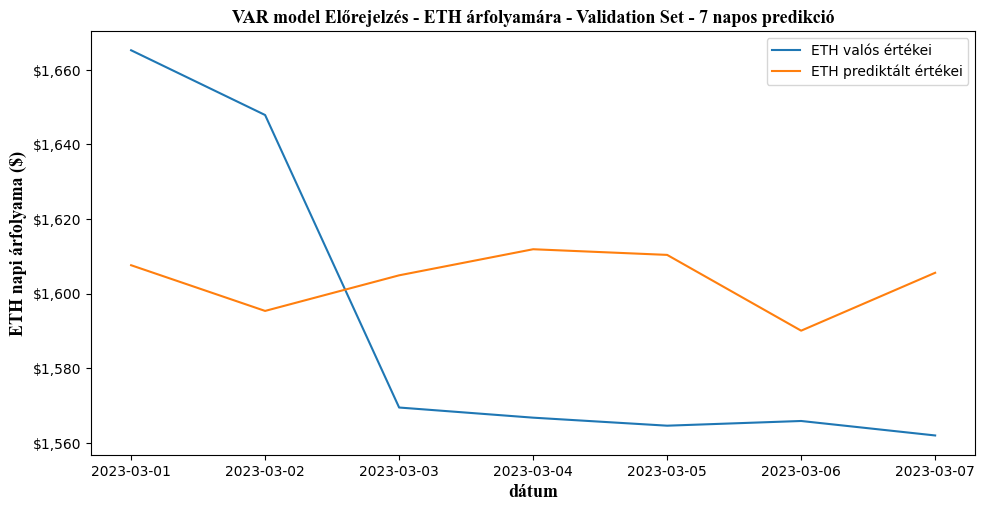

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(evaluation_df["true_values"], label="ETH valós értékei")
ax.plot(evaluation_df["predicted_values"], label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
ax.set_title("VAR model Előrejelzés - ETH árfolyamára - Validation Set - 7 napos predikció", **font)
plt.savefig("charts/forecast/var_forecast_example7day.png")
plt.show()

## 14 DAY 

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2017-09-01 to 2023-03-07
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   eth_low                   2014 non-null   float64
 1   eth_high                  2014 non-null   float64
 2   eth_open                  2014 non-null   float64
 3   eth_close                 2014 non-null   float64
 4   eth_volume                2014 non-null   float64
 5   eth_qav                   2014 non-null   float64
 6   eth_num_trades            2014 non-null   float64
 7   eth_taker_base_vol        2014 non-null   float64
 8   eth_taker_quote_vol       2014 non-null   float64
 9   btc_close                 2014 non-null   float64
 10  btc_volume                2014 non-null   float64
 11  btc_num_trades            2014 non-null   float64
 12  btc_qav                   2014 non-null   float64
 13  fed_eff_funds_rate_close  2014 non-null   flo

In [32]:
columns = ['eth_open', 'eth_qav', 'btc_close', 
           'us_treasury_10yt3m_diff', 'news_sentiment',
           'sp500_close', 'unique_whales',
           'twitter_sentiment','nasdaq_close', 'gold_value', 'whales_tx_number',
           'macd', 'ma_26', 'eth_close']

test_size = 14
original_df = df
dataframe = df_stationary
maxlags = 14

In [33]:
tss = TimeSeriesSplit(n_splits=10, test_size=test_size, gap=0)

root_mean_squared_errors = []
mean_squared_errors = []
mean_absolute_errors = []
mean_absolute_percentage_errors = []

df_log = np.log(original_df[1:])
cols = columns
dataframe = dataframe[cols]

for train_idx, val_idx in tss.split(dataframe):
    scaler = StandardScaler()
    train = dataframe.iloc[train_idx]
    test = dataframe.iloc[val_idx]

    ## Original LOG values

    original_logs = pd.DataFrame()
    original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
    original_logs = original_logs[["eth_close"]]    

    ##SCALING
    scaler.fit(train[cols])
    train[cols] = scaler.transform(train[cols])
    test[cols]= scaler.transform(test[cols])
    
    train = pd.DataFrame(train, columns=cols)
    test = pd.DataFrame(test, columns=cols)

    #Model Fit
    model = VAR(train)
    results = model.fit(maxlags=maxlags)
    lag_order = results.k_ar

    prior = train.iloc[-lag_order:][cols].to_numpy()
    fcast = results.forecast(prior, len(test))

    prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
    prediction.index = test.index
    prediction.columns = ["scaled_prediction"]
    backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
    prediction["unscaled_predictions"] = backscaled_fcast[:, -1]

    evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    
    
    ##UN-DIFFERENCING
    x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
    evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff
    
    ##EXP
    evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
    evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    evaluation_df = evaluation_df[1:]
    
try:
    rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
    root_mean_squared_errors.append(rmse)
    mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
    mean_squared_errors.append(mse)        
    mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_errors.append(mae)
    mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_percentage_errors.append(mape)
except:
    pass

print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")

Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 39.5418
MSE: 1563.5552
MAE: 34.9909
MAPE: 2.1999%


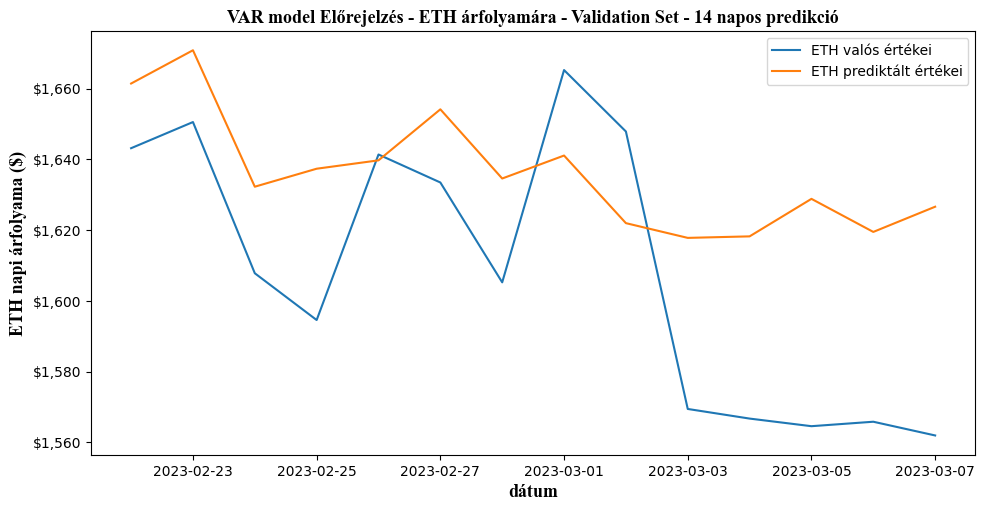

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(evaluation_df["true_values"], label="ETH valós értékei")
ax.plot(evaluation_df["predicted_values"], label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
ax.set_title("VAR model Előrejelzés - ETH árfolyamára - Validation Set - 14 napos predikció", **font)
plt.savefig("charts/forecast/var_forecast_example.png")
plt.show()

## Test on Real-World dataset


## 1 DAY

In [35]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [36]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [37]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=0)] ## 1 day

In [38]:
eth_current_price = eth_current_price[["Close"]]

In [39]:
eth_current_price.index.freq="D"

In [40]:
columns = ['eth_taker_base_vol', 'eth_taker_quote_vol', 'sp500_close', 'us_breake_inf_rate_5y',
       'unique_whales', 'rsi', 'ma_12', 'ma_26',
       'upper_band', 'middle_band', 'lower_band',
       'macd', 'signal', 'hist', 'obv',
       'eth_close']

original_df = df
maxlags = 14

In [41]:
scaler = StandardScaler()
train = df_stationary[columns]
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

In [42]:
train.head()

,eth_taker_base_vol,eth_taker_quote_vol,sp500_close,us_breake_inf_rate_5y,unique_whales,rsi,ma_12,ma_26,upper_band,middle_band,lower_band,macd,signal,hist,obv,eth_close
0,1.057912,0.828082,-0.021376,-0.006037,-2.014157,-2.891105,0.258859,0.228984,-0.071636,-0.115513,-0.058756,-0.253863,0.091231,-0.465200,-0.034374,-2.384236
1,-0.225370,-0.297937,-0.021376,-0.006037,-0.723173,-0.079506,0.443890,0.179774,-0.430036,-0.429710,-0.035781,-0.229630,0.002763,-0.343144,-0.030472,-0.089675
2,0.642859,0.306111,-0.021376,-0.006037,1.905666,-3.167671,-0.542291,-0.492185,-0.540733,-1.272404,-0.933064,-0.674758,-0.203590,-0.802206,-0.032411,-3.567769
3,0.882472,0.832912,-0.706544,-0.859510,0.338250,1.883719,-0.224855,-0.257860,-1.098620,-1.004900,0.019734,-0.304348,-0.255852,-0.202150,-0.012705,1.804979
4,-1.603442,-1.336178,0.261014,0.338550,-0.714888,1.126161,0.071158,-0.049891,-0.012866,0.341251,0.423848,-0.055247,-0.221790,0.134012,-0.016439,1.340746


In [43]:
## Original LOG values
df_log = np.log(original_df[1:])
df_log = pd.concat([df_log.iloc[-1:], eth_current_price])
df_log.index.freq="D"
df_log.rename(columns={"eth_close": "log_close"}, inplace=True)
df_log.rename(columns={"Close": "eth_close"}, inplace=True)

In [44]:
model = VAR(train)
results = model.fit(maxlags=maxlags)
lag_order = results.k_ar

In [45]:
prior = train.iloc[-lag_order:][columns].to_numpy()
fcast = results.forecast(prior, len(eth_current_price))

In [46]:
prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
prediction.index = eth_current_price.index
prediction.columns = ["scaled_prediction"]
backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
prediction["unscaled_predictions"] = backscaled_fcast[:, -1]

In [47]:
evaluation_df = pd.merge(df_log[["log_close", "eth_close"]], prediction, how="left", left_index=True, right_index=True)   

In [48]:
x, x_diff = evaluation_df['log_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') 

In [49]:
evaluation_df = evaluation_df.iloc[1:]
evaluation_df = evaluation_df[["eth_close", "log_prediction"]]
evaluation_df.rename(columns={"eth_close": "true_values"}, inplace=True)

In [50]:
##EXP
evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    
try:
    rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
    mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
    mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
except:
    pass

print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

RMSE: 4.3075
MSE: 18.555
MAE: 4.3075
MAPE: 0.2808%


## 3 DAY

In [51]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [52]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [53]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=2)] ## 3 day

In [54]:
eth_current_price = eth_current_price[["Close"]]

In [55]:
eth_current_price.index.freq="D"

In [56]:
columns = ['eth_open', 'eth_qav', 'btc_close', 
           'us_treasury_10yt3m_diff', 'news_sentiment',
           'sp500_close', 'unique_whales',
           'twitter_sentiment','nasdaq_close', 'gold_value', 'whales_tx_number',
           'macd', 'ma_26', 'eth_close']



original_df = df
maxlags = 14

In [57]:
scaler = StandardScaler()
train = df_stationary[columns]
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

In [58]:
train.head()

,eth_open,eth_qav,btc_close,us_treasury_10yt3m_diff,news_sentiment,sp500_close,unique_whales,twitter_sentiment,nasdaq_close,gold_value,whales_tx_number,macd,ma_26,eth_close
0,0.092322,1.353227,-1.918937,0.024136,-0.000150,-0.021376,-2.014157,-0.499635,-0.026076,0.458633,-1.504819,-0.253863,0.228984,-2.384236
1,-2.368262,-1.137789,0.181993,0.024136,-0.000150,-0.021376,-0.723173,1.165077,-0.026076,-0.021764,-1.098007,-0.229630,0.179774,-0.089675
2,-0.252478,0.243115,-2.335214,0.024136,-0.000150,-0.021376,1.905666,-2.058867,-0.026076,0.971313,2.487770,-0.674758,-0.492185,-3.567769
3,-3.226923,0.419379,1.515214,-2.174336,-0.893981,-0.706544,0.338250,0.843398,-0.712563,-0.051784,-0.029339,-0.304348,-0.257860,1.804979
4,1.675599,-0.693993,1.355587,-0.195711,-0.000150,0.261014,-0.714888,1.140331,0.203584,0.434043,-0.343514,-0.055247,-0.049891,1.340746


In [59]:
## Original LOG values
df_log = np.log(original_df[1:])
df_log = pd.concat([df_log.iloc[-1:], eth_current_price])
df_log.index.freq="D"
df_log.rename(columns={"eth_close": "log_close"}, inplace=True)
df_log.rename(columns={"Close": "eth_close"}, inplace=True)

In [60]:
model = VAR(train)
results = model.fit(maxlags=maxlags)
lag_order = results.k_ar

In [61]:
prior = train.iloc[-lag_order:][columns].to_numpy()
fcast = results.forecast(prior, len(eth_current_price))

In [62]:
prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
prediction.index = eth_current_price.index
prediction.columns = ["scaled_prediction"]
backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
prediction["unscaled_predictions"] = backscaled_fcast[:, -1]

In [63]:
evaluation_df = pd.merge(df_log[["log_close", "eth_close"]], prediction, how="left", left_index=True, right_index=True)   

In [64]:
x, x_diff = evaluation_df['log_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') 

In [65]:
evaluation_df = evaluation_df.iloc[1:]
evaluation_df = evaluation_df[["eth_close", "log_prediction"]]
evaluation_df.rename(columns={"eth_close": "true_values"}, inplace=True)

In [66]:
##EXP
evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    
try:
    rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
    mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
    mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
except:
    pass

print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

RMSE: 98.9691
MSE: 9794.8838
MAE: 91.7504
MAPE: 6.3393%


In [67]:
evaluation_df

,true_values,log_prediction,predicted_values
2023-03-08,1534.088257,7.360996,1573.402344
2023-03-09,1438.660767,7.349177,1554.915717
2023-03-10,1429.158081,7.345262,1548.840329


## 7 DAY

In [68]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [69]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [70]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=6)] ## 1 day

In [71]:
eth_current_price = eth_current_price[["Close"]]

In [72]:
eth_current_price.index.freq="D"

In [73]:
columns = ['btc_close', 'news_sentiment',
           'unique_whales', 'signal',
           'us_treasury_10yt3m_diff','sp500_close',
           'nasdaq_close', 'gold_value', 'whales_tx_number',
           'macd', 'eth_close']


original_df = df
maxlags = 14

In [74]:
scaler = StandardScaler()
train = df_stationary[columns]
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

In [75]:
train.head()

,btc_close,news_sentiment,unique_whales,signal,us_treasury_10yt3m_diff,sp500_close,nasdaq_close,gold_value,whales_tx_number,macd,eth_close
0,-1.918937,-0.000150,-2.014157,0.091231,0.024136,-0.021376,-0.026076,0.458633,-1.504819,-0.253863,-2.384236
1,0.181993,-0.000150,-0.723173,0.002763,0.024136,-0.021376,-0.026076,-0.021764,-1.098007,-0.229630,-0.089675
2,-2.335214,-0.000150,1.905666,-0.203590,0.024136,-0.021376,-0.026076,0.971313,2.487770,-0.674758,-3.567769
3,1.515214,-0.893981,0.338250,-0.255852,-2.174336,-0.706544,-0.712563,-0.051784,-0.029339,-0.304348,1.804979
4,1.355587,-0.000150,-0.714888,-0.221790,-0.195711,0.261014,0.203584,0.434043,-0.343514,-0.055247,1.340746


In [76]:
## Original LOG values
df_log = np.log(original_df[1:])
df_log = pd.concat([df_log.iloc[-1:], eth_current_price])
df_log.index.freq="D"
df_log.rename(columns={"eth_close": "log_close"}, inplace=True)
df_log.rename(columns={"Close": "eth_close"}, inplace=True)

In [77]:
model = VAR(train)
results = model.fit(maxlags=maxlags)
lag_order = results.k_ar

In [78]:
prior = train.iloc[-lag_order:][columns].to_numpy()
fcast = results.forecast(prior, len(eth_current_price))

In [79]:
prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
prediction.index = eth_current_price.index
prediction.columns = ["scaled_prediction"]
backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
prediction["unscaled_predictions"] = backscaled_fcast[:, -1]

In [80]:
evaluation_df = pd.merge(df_log[["log_close", "eth_close"]], prediction, how="left", left_index=True, right_index=True)   

In [81]:
x, x_diff = evaluation_df['log_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') 

In [82]:
evaluation_df = evaluation_df.iloc[1:]
evaluation_df = evaluation_df[["eth_close", "log_prediction"]]
evaluation_df.rename(columns={"eth_close": "true_values"}, inplace=True)

In [83]:
##EXP
evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    
try:
    rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
    mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
    mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
except:
    pass

print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

RMSE: 90.0202
MSE: 8103.6359
MAE: 79.6972
MAPE: 5.2523%


## 14 DAY

In [84]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [85]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [86]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=13)] ## 14 day

In [87]:
eth_current_price = eth_current_price[["Close"]]

In [88]:
eth_current_price.index.freq="D"

In [89]:
columns = ['eth_open', 'eth_qav', 'btc_close', 
           'us_treasury_10yt3m_diff', 'news_sentiment',
           'sp500_close', 'unique_whales',
           'twitter_sentiment','nasdaq_close', 'gold_value', 'whales_tx_number',
           'macd', 'ma_26', 'eth_close']


original_df = df
maxlags = 14

In [90]:
scaler = StandardScaler()
train = df_stationary[columns]
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

In [91]:
## Original LOG values
df_log = np.log(original_df[1:])
df_log = pd.concat([df_log.iloc[-1:], eth_current_price])
df_log.index.freq="D"
df_log.rename(columns={"eth_close": "log_close"}, inplace=True)
df_log.rename(columns={"Close": "eth_close"}, inplace=True)

In [92]:
model = VAR(train)
results = model.fit(maxlags=maxlags)
lag_order = results.k_ar

In [93]:
prior = train.iloc[-lag_order:][columns].to_numpy()
fcast = results.forecast(prior, len(eth_current_price))

In [94]:
prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
prediction.index = eth_current_price.index
prediction.columns = ["scaled_prediction"]
backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
prediction["unscaled_predictions"] = backscaled_fcast[:, -1]

In [95]:
evaluation_df = pd.merge(df_log[["log_close", "eth_close"]], prediction, how="left", left_index=True, right_index=True)   

In [96]:
x, x_diff = evaluation_df['log_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') 

In [97]:
evaluation_df = evaluation_df.iloc[1:]
evaluation_df = evaluation_df[["eth_close", "log_prediction"]]
evaluation_df.rename(columns={"eth_close": "true_values"}, inplace=True)

In [98]:
##EXP
evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    
try:
    rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
    mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
    mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
except:
    pass

print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

RMSE: 114.0517
MSE: 13007.799
MAE: 102.6807
MAPE: 6.157%


In [99]:
evaluation_df

,true_values,log_prediction,predicted_values
2023-03-08,1534.088257,7.360996,1573.402344
2023-03-09,1438.660767,7.349177,1554.915717
2023-03-10,1429.158081,7.345262,1548.840329
2023-03-11,1482.616699,7.347547,1552.383908
2023-03-12,1590.292969,7.356553,1566.428431
2023-03-13,1680.308960,7.370528,1588.472312
2023-03-14,1703.507080,7.378380,1600.993284
2023-03-15,1656.180542,7.386609,1614.222339
2023-03-16,1677.215454,7.391475,1622.096371
2023-03-17,1792.485107,7.386895,1614.684124


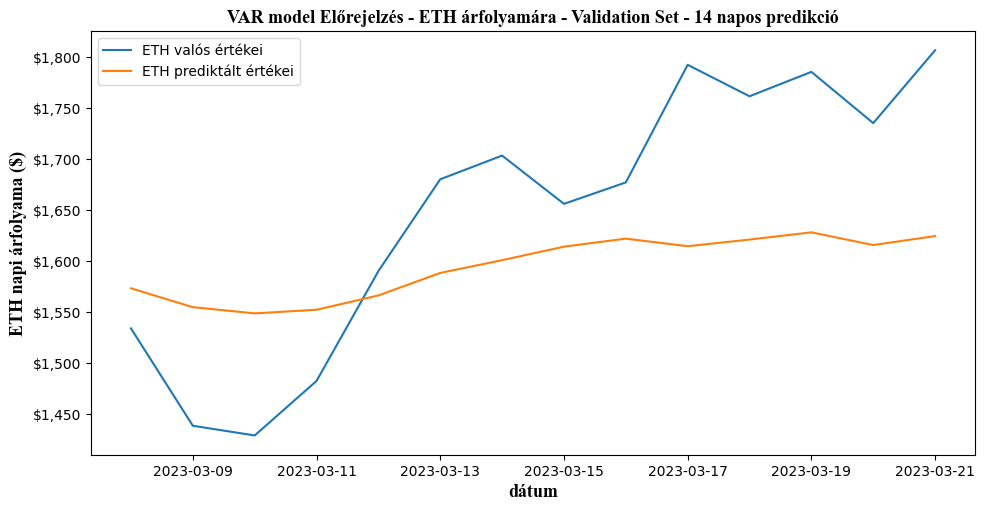

In [100]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(evaluation_df["true_values"], label="ETH valós értékei")
ax.plot(evaluation_df["predicted_values"], label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
ax.set_title("VAR model Előrejelzés - ETH árfolyamára - Validation Set - 14 napos predikció", **font)
plt.savefig("charts/forecast/var_forecast_realworld_example.png")
plt.show()

## BACKUP

In [101]:
def gridsearch_timeseriessplit(dataframe, original_df, test_size=1, maxlags=14):
    
    tss = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=0)

    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []

    df_log = np.log(original_df[1:])
    cols = dataframe.columns.tolist()

    for train_idx, val_idx in tss.split(dataframe):
        #scaler = StandardScaler()
        train = dataframe.iloc[train_idx]
        test = dataframe.iloc[val_idx]

        ## Original LOG values

        original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
        original_logs = original_logs[["eth_close"]]    

        ##SCALING
        #train[cols] = scaler.fit_transform(train)
        #test[cols] = scaler.transform(test)

        
        train = dataframe.iloc[train_idx]
        test = dataframe.iloc[val_idx]
        
        #Model Fit
        model = VAR(train)
        results = model.fit(maxlags=maxlags)
        lag_order = results.k_ar

        prior = train.iloc[-lag_order:][cols].to_numpy()
        fcast = results.forecast(prior, len(test))

        prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
        prediction.index = test.index
        prediction.columns = ["difference_prediction"]

        evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    
        
        ##UN-DIFFERENCING
        x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['difference_prediction'].iloc[1:]
        evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff
        
        print(evaluation_df["log_prediction"])
        ##EXP
        evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
        evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
        evaluation_df = evaluation_df[1:]
    
    rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
    root_mean_squared_errors.append(rmse)
    mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
    mean_squared_errors.append(mse)        
    mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_errors.append(mae)
    mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
    mean_absolute_percentage_errors.append(mape)


    print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    return evaluation_df

In [102]:
dataframe = df_stationary
original_df = df
test_size=14
maxlags=14

In [103]:
tss = TimeSeriesSplit(n_splits=2, test_size=test_size, gap=0)

root_mean_squared_errors = []
mean_squared_errors = []
mean_absolute_errors = []
mean_absolute_percentage_errors = []

df_log = np.log(original_df[1:]) ## direkt első index nélkül
cols = dataframe.columns.tolist()

for train_idx, val_idx in tss.split(dataframe):
    scaler = StandardScaler()
    train = dataframe.iloc[train_idx]
    test = dataframe.iloc[val_idx]

    ## Original LOG values
    original_logs = pd.DataFrame()
    original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
    original_logs = original_logs[["eth_close"]]    

    ##SCALING
    
    scaler.fit(train[cols])
    train[cols] = scaler.transform(train[cols])
    test[cols] = scaler.transform(test[cols])
    
    #Model Fit
    model = VAR(train)
    results = model.fit(maxlags=maxlags)
    lag_order = results.k_ar
    
    prior = train.iloc[-lag_order:][cols].to_numpy()
    fcast = results.forecast(prior, len(test))
    print(fcast[:, -1])
    
    
"""
    print(test["eth_close"])
    print(fcast[:, -1])
    prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
    prediction.index = test.index
    prediction.columns = ["scaled_prediction"]
    backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
    prediction["unscaled_predictions"] = backscaled_fcast[:, -1]
    
    
    evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    

    ##UN-DIFFERENCING
    #x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
    evaluation_df["log_prediction"] = evaluation_df['eth_close'].shift(1) + evaluation_df['unscaled_predictions']
    

    ##EXP
    evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
    evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    evaluation_df = evaluation_df[1:]

rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
root_mean_squared_errors.append(rmse)
mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
mean_squared_errors.append(mse)        
mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mean_absolute_errors.append(mae)
mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mean_absolute_percentage_errors.append(mape)


print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
return evaluation_df

"""

[-0.4149017   0.28921593  0.13512549  0.24132738 -0.44542816 -0.4701006
  0.4118654  -0.21085157  0.44142211 -0.48717615 -0.48490521  0.13370355
  0.1208274  -0.55829666]
[ 2.41157532e-01  8.41827750e+06 -3.07666334e+06  1.37729355e+14
  1.52503421e+14  2.22550452e+21  5.98494371e+21  3.32838471e+28
  1.48208249e+29  4.89879360e+35  3.45251436e+36  7.82130879e+42
  6.62857053e+43  1.16702004e+50]


'\n    print(test["eth_close"])\n    print(fcast[:, -1])\n    prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close\n    prediction.index = test.index\n    prediction.columns = ["scaled_prediction"]\n    backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))\n    prediction["unscaled_predictions"] = backscaled_fcast[:, -1]\n    \n    \n    evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    \n\n    ##UN-DIFFERENCING\n    #x, x_diff = evaluation_df[\'eth_close\'].iloc[0], evaluation_df[\'unscaled_predictions\'].iloc[1:]\n    evaluation_df["log_prediction"] = evaluation_df[\'eth_close\'].shift(1) + evaluation_df[\'unscaled_predictions\']\n    \n\n    ##EXP\n    evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)\n    evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)\n    evaluation_df = evaluation_df[1:]\n\nrmse = mean_squared_error(evaluation_df[\'true_values\']

In [104]:
dataframe = df_stationary
original_df = df
test_size=14
maxlags=14

In [105]:
tss = TimeSeriesSplit(n_splits=2, test_size=test_size, gap=0)

root_mean_squared_errors = []
mean_squared_errors = []
mean_absolute_errors = []
mean_absolute_percentage_errors = []

df_log = np.log(original_df[1:]) ## direkt első index nélkül
cols = ["btc_close","eth_close", "silver_value"]

In [106]:
scaler = StandardScaler()
train = dataframe.iloc[train_idx]
test = dataframe.iloc[val_idx]

## Original LOG values
original_logs = pd.DataFrame()
original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
original_logs = original_logs[["eth_close"]]    

##SCALING

scaler.fit(train[cols])
train[cols] = scaler.transform(train[cols])
test[cols]= scaler.transform(test[cols])

train = pd.DataFrame(train, columns=cols)

#Model Fit
model = VAR(train)
results = model.fit(maxlags=maxlags)
lag_order = results.k_ar

prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, len(test))
print(fcast[:,-1])
print(scaler.inverse_transform(fcast[:, -1]))

[ 0.08096263  0.05616419  0.07180229  0.03250505 -0.1368086  -0.02374753
 -0.24544973 -0.10134118  0.04220029 -0.11125189  0.01673217  0.03036529
  0.01159193  0.02318664]


ValueError: Expected 2D array, got 1D array instead:
array=[ 0.08096263  0.05616419  0.07180229  0.03250505 -0.1368086  -0.02374753
 -0.24544973 -0.10134118  0.04220029 -0.11125189  0.01673217  0.03036529
  0.01159193  0.02318664].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
dataframe = df_stationary
test_size = 25
original_df = df


tss = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=0)

scaler = StandardScaler()
root_mean_squared_errors = []
mean_squared_errors = []
mean_absolute_errors = []
mean_absolute_percentage_errors = []

df_log = np.log(original_df[1:])
cols = dataframe.columns.tolist()

for train_idx, val_idx in tss.split(dataframe):
    train = dataframe.iloc[train_idx]
    test = dataframe.iloc[val_idx]
    
    ## Original LOG values
    
    original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
    original_logs = original_logs[["eth_close"]]    
    
    ##SCALING
    train[cols] = scaler.fit_transform(train)
    test[cols] = scaler.transform(test)

    #Model Fit
    model = VAR(train)
    results = model.fit(maxlags=21)
    lag_order = results.k_ar
    
    prior = train.iloc[-lag_order:][cols].to_numpy()
    fcast = results.forecast(prior, len(test))
    
    prediction = pd.DataFrame(fcast[:,-1]) ##last column contains eth_close
    prediction.index = test.index
    prediction.columns = ["scaled_prediction"]
    backscaled_fcast = scaler.inverse_transform(pd.DataFrame(fcast))
    prediction["unscaled_predictions"] = backscaled_fcast[:, -1]
    
    evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    
            
    x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
    evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum() ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff
    
    evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
    evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
    evaluation_df = evaluation_df[1:]

rmse = mean_squared_error(test['eth_close'], scaler.inverse_transform(prediction.prediction), squared=False)
root_mean_squared_errors.append(rmse)
mse = mean_squared_error(test['eth_close'], scaler.inverse_transform(prediction.prediction), squared=True)
mean_squared_errors.append(mse)        
mae = mean_absolute_error(test['eth_close'],scaler.inverse_transform(prediction.prediction))
mean_absolute_errors.append(mae)
mape = mean_absolute_percentage_error(test['eth_close'],scaler.inverse_transform(prediction.prediction))
mean_absolute_percentage_errors.append(mape)


print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
return train_pred, test[column], fcast, confint

In [ ]:
df[-1:]

In [ ]:
df_log.iloc[train_idx].iloc[-1:]

In [ ]:
pd.concat([pd.DataFrame(df_log.iloc[train_idx].iloc[-1]), df_log.iloc[val_idx]])